# Time Series Similarity Search with aeon

<img src="img/sim_search.png" width="600" alt="time series similarity search">

The objectives of the similarity search module in aeon is to provide estimators with a `fit`/`predict` interface to solve the following use cases :

- Nearest neighbors search on time series subesequences or whole series
- Motifs search on time series subsequences

Similarly to the `transformer` module, the `similarity_search` module split estimators between `series` estimators and `collection` estimators, such as :

- `series` estimators take as input a single time series of shape `(n_channels, n_timepoints)` during fit and predict.
- `collection` estimators take as input a time series collection of shape `(n_cases, n_channels, n_timepoints)` during fit, and a single series of shape  `(n_channels, n_timepoints)` during predict.

Note that the above is a general guideline, and that some estimators can also take  `None` as input during predict, or series of length different to `n_timepoints`. We'll explore the different estimators in the next sections.

### Other similarity search notebooks

This notebook gives an overview of similarity search module and the available estimators. The following notebooks are also avaiable to go more in depth with specific subject of similarity search in aeon:

- [The theory and math behind the similarity search estimators in aeon](distance_profiles.ipynb)
- [Analysis of the performance of the estimators provided by similarity search module](code_speed.ipynb)



In [1]:
# Define some plotting functions we'll use later !
def plot_best_matches(
    X_fit, X_predict, idx_predict, idx_matches, length, normalize=False
):
    """Plot the top best matches of a query in a dataset."""
    fig, ax = plt.subplots(figsize=(20, 5), ncols=len(idx_matches))
    if len(idx_matches) == 1:
        ax = [ax]
    for i_k, id_timestamp in enumerate(idx_matches):
        # plot the sample of the best match
        ax[i_k].plot(X_fit[0], linewidth=2)
        # plot the location of the best match on it
        match = X_fit[0, id_timestamp : id_timestamp + length]
        ax[i_k].plot(
            range(id_timestamp, id_timestamp + length),
            match,
            linewidth=7,
            alpha=0.5,
            color="green",
            label="best match location",
        )
        # plot the query on the location of the best match
        Q = X_predict[0, idx_predict : idx_predict + length]
        if normalize:
            Q = Q * np.std(match) + np.mean(match)
        ax[i_k].plot(
            range(id_timestamp, id_timestamp + length),
            Q,
            linewidth=5,
            alpha=0.5,
            color="red",
            label="query",
        )
        ax[i_k].set_title(f"best match {i_k}")
        ax[i_k].legend()
    plt.show()


def plot_matrix_profile(X, mp, i_k):
    """Plot the matrix profile and corresponding time series."""
    fig, ax = plt.subplots(figsize=(20, 10), nrows=2)
    ax[0].set_title("series X used to build the matrix profile")
    ax[0].plot(X[0])  # plot first channel only
    # This is necessary as mp is a list of arrays due to unequal length support
    # as it can have different number of matches for each step when
    # using threshold-based search.
    ax[1].plot([mp[i][i_k] for i in range(len(mp))])
    ax[1].set_title(f"Top {i_k+1} matrix profile of X")
    ax[1].set_ylabel(f"Dist to top {i_k+1} match")
    ax[1].set_xlabel("Starting index of the query in X")
    plt.show()

### A word on base clases

All estimators of the similarity search module in aeon inherit from the `BaseSimilaritySearch` class, which define the some abstract methods that estimator must implement, such as `fit` and `predict` and some private function used to validate the format of the time series you will provide. Then, the two submodules `series` and `collection` also define a base class (`BaseSeriesSimilaritySearch` and `BaseCollectionSeriesSearch`) that their respective estimator will inherit from. If you ever want to extend the module or create your own estimators, these are the classes you'll want to use to define the base structure of your estimator.

### Load a dataset
In the following, we'll use an easy dataset (`GunPoint`) to help build intuition. Don't hesitate to swap it with other datasets to explore ! We load it using the `load_classification` function.

The GunPoint dataset is composed of two classes which are discriminated by the "bumps" located before and after the central peak. These bumps correspond to an actor drawing a fake gun from a holster before pointing it (hence the name "GunPoint" !). In the second class, the actor simply points his fingers without making the motion of taking the gun out of the holster.

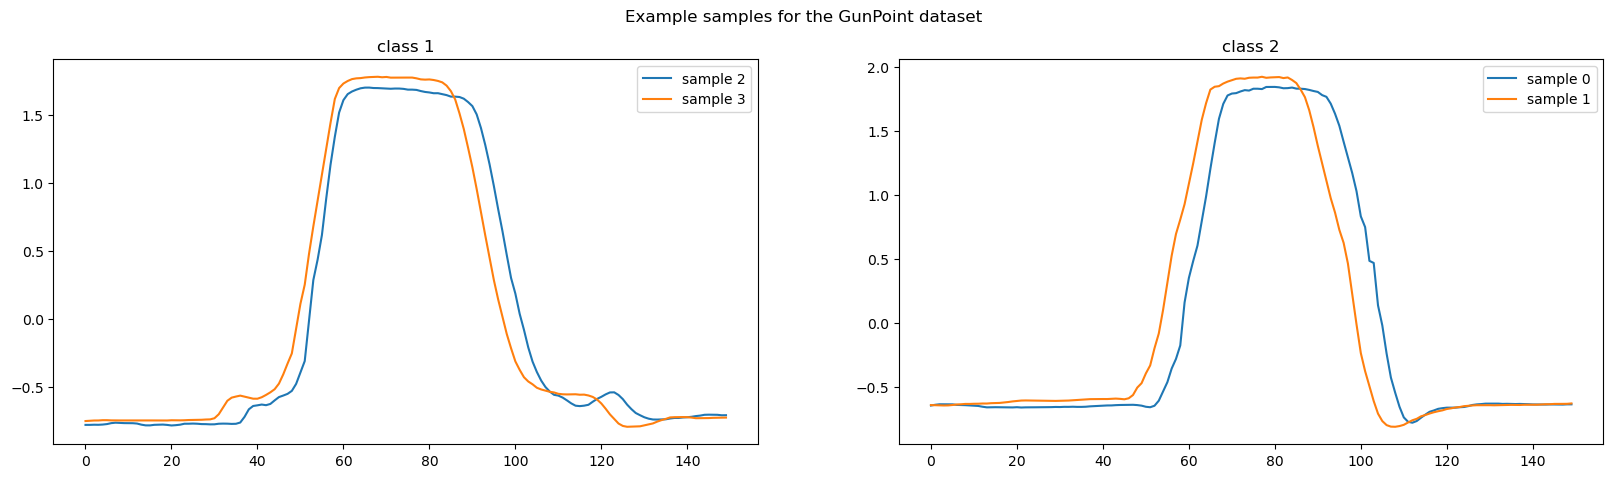

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from aeon.datasets import load_classification

# Load GunPoint dataset
X, y = load_classification("GunPoint")

classes = np.unique(y)

fig, ax = plt.subplots(figsize=(20, 5), ncols=len(classes))
for i_class, _class in enumerate(classes):
    for i_x in np.where(y == _class)[0][0:2]:
        ax[i_class].plot(X[i_x, 0], label=f"sample {i_x}")
    ax[i_class].legend()
    ax[i_class].set_title(f"class {_class}")
plt.suptitle("Example samples for the GunPoint dataset")
plt.show()

## 1. Series estimators

First, we'll explore estimators of the `series` module, where you must provide single series of shape `(n_channels, n_timepoints)` during fit.

### 1.1 Subsequence nearest neighbors with MASS

To perform nearest neighbors search on subsequences on a series, we can use the `MassSNN` estimator.

It takes as parameter during initialisation :
- `length` : an integer giving the length of the subsequences to extract from the series. It is also the expected length of the series given in `predict`
- `normalize`: a boolean indicating wheter the subsequences should be independently z-normalized (`(X-mean(X))/std(X)`) before the distance computations. This results in a scale-independent matching.
  
To parameterize the search, additional parameters are available when calling the `predict` method:

- `k` (int) : the number of nearest neighbors to return.
- `dist_threshold` (float) : the maximum allowed distance for a candidate subsequence to be considered as a neighbor.
- `allow_trivial_matches` (bool) : wheter a neighbors of a match to a query can be also considered as matches (True), or if an exclusion zone is applied around each match to avoid trivial matches with their direct neighbors (False).
- `inverse_distance` (bool) : if True, the matching will be made on the inverse of the distance, and thus, the farther neighbors will be returned instead of the closest ones.
- `exclusion_factor` (float): A factor of the `length` used to define the exclusion zone when `allow_trivial_matches` is set to False. For a given timestamp, the exclusion zone starts from `id_timestamp - length//exclusion_factor` and end at `id_timestamp + length//exclusion_factor`.
- `X_index` (int): If series given during predict is a subsequence of series given during fit, specify its starting timestamp. If specified, neighboring subsequences of X won't be able to match as neighbors.

First, we'll select a series from the dataset to use during fit. This is the series we want our neighbors to come from.

In [3]:
from aeon.similarity_search.series import MassSNN

length = 35
# We'll take a sample of the class with a "bump".
series_fit = X[2]
print(series_fit.shape)
snn = MassSNN(length=length, normalize=False).fit(series_fit)

(1, 150)


Then we'll take a subsequence of size `length` in another series of the same class to use in `predict` :

match 0 : 27 with distance 0.3020071566139322
match 1 : 28 with distance 0.48913603040398357
match 2 : 26 with distance 0.889697094966067


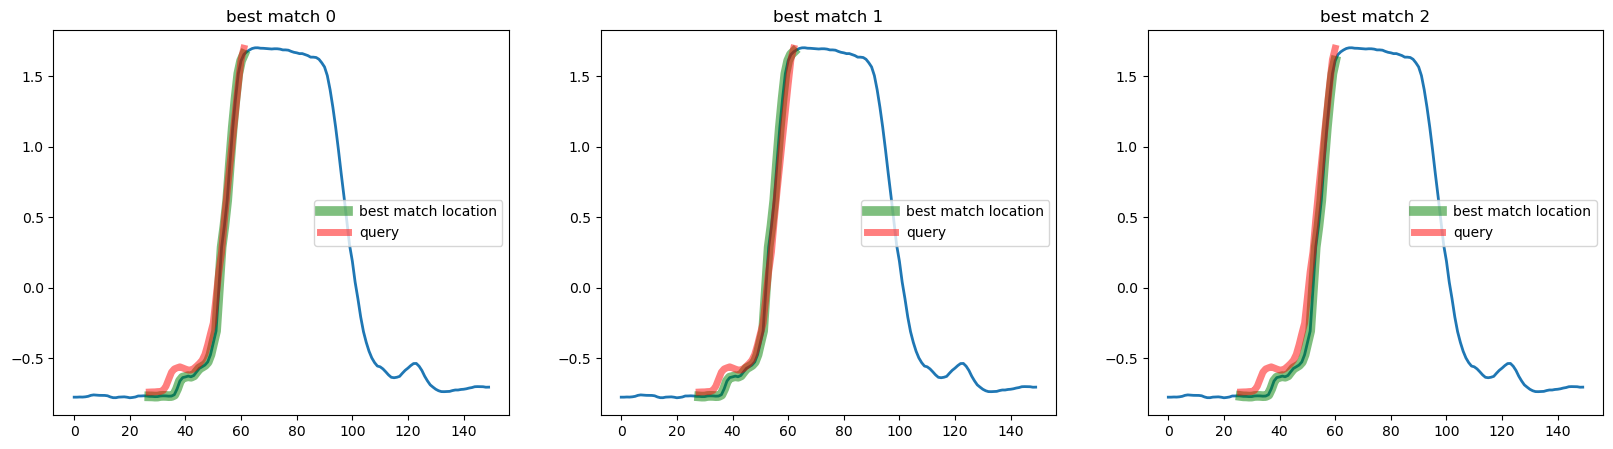

In [4]:
series_predict = X[3]
starting_timestep_predict = 25
indexes, distances = snn.predict(
    series_predict[:, starting_timestep_predict : starting_timestep_predict + length],
    k=3,
    allow_trivial_matches=True,
)
for i in range(len(indexes)):
    print(f"match {i} : {indexes[i]} with distance {distances[i]}")
plot_best_matches(
    series_fit, series_predict, starting_timestep_predict, indexes, length
)

The `predict` method returns two lists, containing the starting timesteps of the matches in `series_fit` and the squared euclidean distance of these matches to the subsequence we gave in `predict`. Now, you can then play with the different parameters of `predict` to customize your search results to your needs!

It is also possible to get the distance profile which is used to extract the best matches :

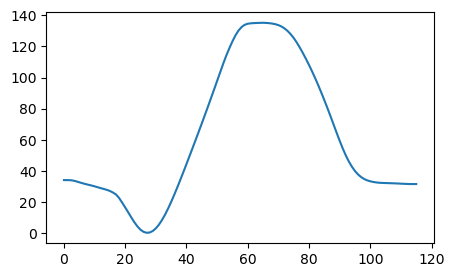

In [5]:
distance_profile = snn.compute_distance_profile(
    series_predict[:, starting_timestep_predict : starting_timestep_predict + length],
)
plt.figure(figsize=(5, 3))
plt.plot(distance_profile)
plt.show()

### 1.2 Motif search with STOMP

In [6]:
from aeon.similarity_search.series import StompMotif

motif = StompMotif(length=length).fit(series_fit)
motif.predict(series_predict)

([array([0.02910451])], [array([[7, 0]], dtype=int64)])